### Import Modules

In [1]:
import pandas as pd
import numpy as np
eps = np.finfo(float).eps

from sklearn import decomposition
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

from typing import NoReturn, Callable

### Read Dataset

In [2]:
df = pd.read_csv('datasets/preprocessed.csv')
df.set_index('region', inplace=True)

In [3]:
df

,turnover,first,second,third
region,,,,
Вінницька,18287.8,85.0,103.3,98.5
Волинська,13755.0,85.0,95.0,96.4
Дніпропетровська,51951.8,80.1,103.7,99.1
Донецька2,19145.0,29.3,87.8,61.2
Житомирська,15879.1,87.3,101.7,99.7
Закарпатська,13672.4,85.5,103.4,98.4
Запорізька,27131.5,82.1,100.8,98.0
Івано-Франківська,17993.8,84.9,101.0,99.8
Київська,28775.5,86.6,104.8,96.8


### Normalize Data

In [4]:
scaler = preprocessing.StandardScaler()
scaled = pd.DataFrame(
    data=scaler.fit_transform(df.values),
    index=df.index,
    columns=df.columns,
)

### Distances and Metrics

In [5]:
def minkowski(data: np.ndarray, centroids: np.ndarray, power: int = 2) -> np.ndarray:
    return np.sum((centroids - data[:, None, :]) ** power, axis=2) ** (1 / power)

def inertia(data: np.ndarray, centroids: np.ndarray, targets: np.ndarray) -> float:
    return np.sqrt(np.square(centroids[targets] - data).sum())

### K-Means Naive Implementation

In [6]:
class KMeans():
    
    def __init__(self, n_clusters: int, distance: Callable = minkowski, metric: Callable = inertia, max_iters: int = 300, threshold: float = 0.0001) -> NoReturn:

        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.distance = distance
        self.metric = metric
        self.threshold = threshold
    
    def initialize(self, data: np.ndarray) -> np.ndarray:
        '''Initialize centroids with K-Means++ algorithm'''
        
        num_samples, dim = data.shape
        centroids = np.empty((self.n_clusters, dim))
        
        idx = np.random.choice(num_samples)
        centroids[0] = data[idx]
        
        for num in range(1, self.n_clusters):
            
            distance = np.min(self.distance(data, centroids), axis=1) + eps
            probs = distance / np.sum(distance)
            
            idx = np.random.choice(num_samples, replace=False, p=probs)
            centroids[num] = data[idx]
            
        return centroids
    
    def get_targets(self, data: np.ndarray) -> np.ndarray:
        '''Identify cluster for each sample'''
        
        distance = self.distance(data, self.centroids)
        return np.argmin(distance, axis=1)
    
    def compute_centroids(self, data: np.array) -> np.ndarray:
        '''Compute new centroids as mean of all samples in each cluster'''
        centroids = np.empty_like(self.centroids)
        
        for target in np.unique(self.targets):
            centroids[target] = np.mean(data[self.targets == target], axis=0)
        
        return centroids
    
    def is_converged(self, centroids: np.ndarray) -> bool:
        '''Check if Frobenius norm is less than threshold'''
        
        norm = np.sqrt(np.square(self.centroids - centroids).sum())
        return norm <= self.threshold
    
    def compute_inertia(self, data: np.ndarray) -> float:
        '''Compute quality functional'''
        
        return self.metric(data, self.centroids, self.targets)
    
    def fit(self, data: np.ndarray) -> np.ndarray:
        '''Clusterize data with K-Means'''
        
        self.centroids = self.initialize(data)
        
        for idx in range(self.max_iters):
            self.targets = self.get_targets(data)

            centroids = self.centroids
            self.centroids = self.compute_centroids(data)
            
            if self.is_converged(centroids): break
            self.inertia = self.compute_inertia(data)

        return self.targets

### Elbow Method

In [7]:
def elbow_method(min_clusters: int = 1, max_clusters: int = 10) -> np.ndarray:
    
    num_clusters = np.arange(min_clusters, max_clusters)
    inertias = []
    
    for num in num_clusters:
        kmeans = KMeans(n_clusters=num)
        kmeans.fit(scaled.values)
        inertias.append(kmeans.inertia)
    
    def plot_elbow() -> NoReturn:
        
        plt.figure(figsize=(8, 8))
        plt.plot(num_clusters, inertias, '-ro')
        
        plt.xlabel('Num Clusters')
        plt.ylabel('Inertia')

    plot_elbow()
    return inertias

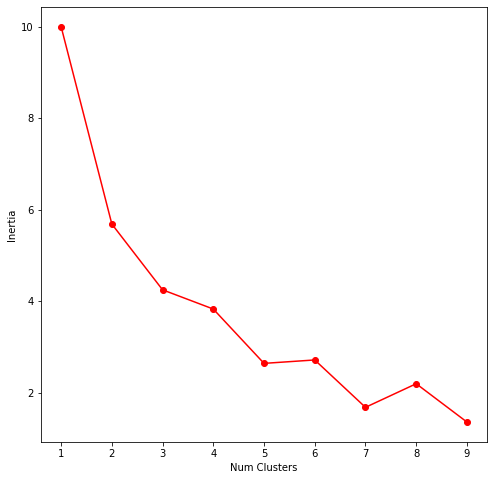

In [8]:
_ = elbow_method()

In [9]:
num_clusters = 5

### Clusterize Data

In [10]:
kmeans = KMeans(num_clusters)
clusters = kmeans.fit(scaled.values)

### Centroids

In [11]:
np.round(kmeans.centroids, 3)

array([[ 1.942,  0.223,  0.24 ,  0.193],
       [-1.015, -3.681, -3.688, -3.973],
       [-0.187, -2.959, -2.327, -2.57 ],
       [-0.29 ,  0.113, -0.329,  0.099],
       [-0.366,  0.37 ,  0.479,  0.377]])

### Visualize Clusterization

#### Project in 2D space

In [12]:
pca = decomposition.PCA(n_components=2)
norm = pca.fit_transform(scaled.values)

target2d = pd.DataFrame(
    data=np.hstack((norm, clusters[:, None])),
    index=df.index,
    columns=['xx', 'yy', 'target'],
)
target2d.head()

,xx,yy,target
region,,,
Вінницька,-0.674488,-0.343827,4.0
Волинська,0.314716,-0.405434,3.0
Дніпропетровська,-0.856953,1.570646,0.0
Донецька2,4.517725,0.458031,2.0
Житомирська,-0.622552,-0.460268,4.0


### Plot Clustered Data

<AxesSubplot:xlabel='xx', ylabel='yy'>

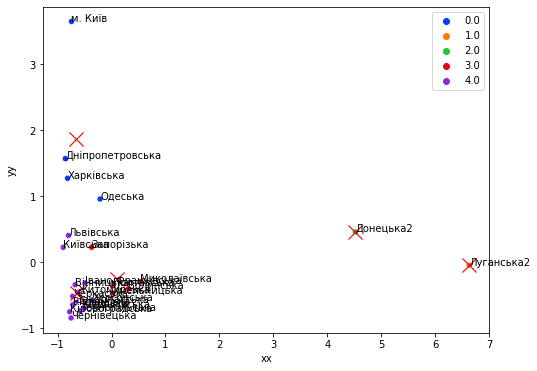

In [13]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x='xx', y='yy', hue='target',
    data=target2d, 
    palette='bright'
)
for idx, label in enumerate(target2d.index):
    xy = target2d.iloc[idx][['xx', 'yy']]
    plt.annotate(text=label, xy=xy)
    
sns.scatterplot(
    x='xx', y='yy', s=200,
    marker='x', color='red',
    data=target2d.groupby('target').agg('mean')
)